# Individual Assignment 4: **Missing Data**
The selected project was topic A.

After selecting a few datasets without missing data for analysis, we induced missing data on them with different mechanisms (MCAR, MAR and MNAR). Then, we apply different techniques to deal with this missing data and compare the different missing data mechanisms and techniques.

The datasets chosen to experiment were:
- **Mobile price classification**: multi-class classification
- **Milk quality prediction**: multi-class classficiation

We experimented with the following techniques:
- [Simple statistical imputation](https://scikit-learn.org/1.6/modules/generated/sklearn.impute.SimpleImputer.html)
- [KNN imputation](https://scikit-learn.org/1.5/modules/generated/sklearn.impute.KNNImputer.html)
- [Iterative imputation](https://scikit-learn.org/1.5/modules/generated/sklearn.impute.IterativeImputer.html)

Finally, we evaluated these techniques and were able to compare them using these metrics:
- **Classification performance**: accuracy
- **Predictive accuracy**: mean absolute error (numerical features) and accuracy (binary features)
- **Distributional accuracy**: KS distance (only numerical features)

The index for the different sections of the notebook is as follows:
1. [**Datasets and Preprocessing**](#datasets)
2. [**Experiments Setup**](#experiments-setup)
3. [**Missing Data Generation**](#missing-data-generation)
4. [**Evaluation Metrics Setup**](#evaluation-metrics-setup)
5. [**Model Pipeline**](#model-pipeline)
6. [**Results and plots**](#results-and-plots)

The required libraries to run the notebook and their specific versions are below:

In [1]:
%pip install -qU pandas==2.2.3 scikit-learn==1.6.0 seaborn==0.13.2 matplotlib==3.10.0 mdatagen==0.1.71 setuptools==75.6.0

Note: you may need to restart the kernel to use updated packages.


Note that we used Python 3.12.3 to test and run the notebook.

In [2]:
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, mean_absolute_error

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from mdatagen.univariate.uMCAR import uMCAR
from mdatagen.univariate.uMAR import uMAR
from mdatagen.univariate.uMNAR import uMNAR
from mdatagen.multivariate.mMCAR import mMCAR
from mdatagen.multivariate.mMAR import mMAR
from mdatagen.multivariate.mMNAR import mMNAR

from scipy.stats import ks_2samp

import seaborn as sns
import matplotlib.pyplot as plt

from typing import Callable

## Datasets

In [3]:
def load_mobile_price() -> pd.DataFrame:
    mobile_price = pd.read_csv("mobile_price.csv")
    mobile_price.rename(columns={"price_range": "target"}, inplace=True)
    return mobile_price

def load_milk_quality() -> pd.DataFrame:
    milk_quality = pd.read_csv("milk_quality.csv")
    milk_quality.rename(columns={"Grade": "target"}, inplace=True)

    mapping = {"low": 0, "medium": 1, "high": 2}
    milk_quality["target"] = milk_quality["target"].map(mapping)
    return milk_quality

def load_datasets():
    """Loads the datasets and returns a dictionary of dataset labels and dataframes"""
    mobile_price = load_mobile_price()
    print(mobile_price.columns)

    milk_quality = load_milk_quality()
    print(milk_quality.columns)

    return {
        "mobile_price": mobile_price,
        "milk_quality": milk_quality,
    }

## Experiments Setup

In [4]:
RANDOM_STATE = 42

In [5]:
class MyImputer:
    def __init__(self, general = None, numerical = None, binary = None):
        self.general = general
        self.numerical = numerical
        self.binary = binary

In [6]:
MISSING_RATES = [10]
MISSING_TECHNIQUES = {
    "Simple": MyImputer(
        numerical=SimpleImputer(strategy="mean"),
        binary=SimpleImputer(strategy="most_frequent"),
    ),
    "Iterative": MyImputer(general=IterativeImputer(max_iter=50, random_state=RANDOM_STATE)),
    "KNN": MyImputer(general=KNNImputer()),
    "NONE": None,
}

MODELS = [LogisticRegression(), RandomForestClassifier(), MLPClassifier(max_iter=1000)]
ALLOW_MISSING_DATA = [False, True, False]

METRICS = ["accuracy", "precision", "recall", "f1"]

In [7]:
assert(len(MODELS) == len(ALLOW_MISSING_DATA))

In [8]:
def mcar_univariate(X, y, missing_rate) -> pd.DataFrame:
    generator = uMCAR(X=X, y=y, missing_rate=missing_rate, method="max")
    return generator.random()

def mcar_multivariate(X, y, missing_rate) -> pd.DataFrame:
    generator = mMCAR(X=X, y=y, missing_rate=missing_rate)
    df = generator.random()
    df["target"] = y
    return df

def mar_univariate(X, y, missing_rate) -> pd.DataFrame:
    generator = uMAR(X=X, y=y, missing_rate=missing_rate)
    return generator.lowest()

def mar_multivariate(X, y, missing_rate) -> pd.DataFrame:
    generator = mMAR(X=X, y=y, n_xmiss=2)
    # Here, we need to divide by 2, otherwise too much missing data will be generated
    new_df = generator.correlated(missing_rate=missing_rate/2)
    new_df["target"] = y
    return new_df

def mnar_univariate(X, y, missing_rate) -> pd.DataFrame:
    generator = uMNAR(X=X, y=y, missing_rate=missing_rate, threshold=0)
    return generator.run()

def mnar_multivariate(X, y, missing_rate) -> pd.DataFrame:
    generator = mMNAR(X=X, y=y, n_xmiss=2, threshold=0)
    new_df = generator.MBOUV(missing_rate=missing_rate)
    new_df["target"] = y
    return new_df

MISSING_MECHANISMS = {
    "Uni MCAR": mcar_univariate,
    "Multi MCAR": mcar_multivariate,
    "Uni MAR": mar_univariate,
    "Multi MAR": mar_multivariate,
    "Uni MNAR": mnar_univariate,
    "Multi MNAR": mnar_multivariate,
}

In [9]:
def count_missing_values(df: pd.DataFrame) -> pd.Series:
    count = df.isna().sum()
    return count[count > 0]
def print_missing_values(count: pd.Series) -> None:
    if len(count) == 0:
        return print("No missing values")
    print(count)

In [10]:
initial_dfs = load_datasets()

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'target'],
      dtype='object')
Index(['pH', 'Temprature', 'Taste', 'Odor', 'Fat ', 'Turbidity', 'Colour',
       'target'],
      dtype='object')


We selected datasets without missing values to completely control the present missing data mechanisms.

In [11]:
for label, df in initial_dfs.items():
    print(f"Dataset {label}")
    print_missing_values(count_missing_values(df))

Dataset mobile_price
No missing values
Dataset milk_quality
No missing values


In [12]:
for label, df in initial_dfs.items():
    print(f"Dataset {label}")
    print(df.info())
    print(df["target"].value_counts())

Dataset mobile_price
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   

## Missing Data Generation

In [13]:
missing_data_dfs = []
for dataset_label, df in initial_dfs.items():
    for missing_rate in MISSING_RATES:
        # Target variable should be named "target"
        X = df.drop("target", axis=1)
        y = df["target"].values

        for missing_mechanism_label, missing_data_generator in MISSING_MECHANISMS.items():
            new_df = missing_data_generator(X=X, y=y, missing_rate=missing_rate)

            missing_data_dfs.append({
                "mechanism": missing_mechanism_label,
                "missing_rate": missing_rate,
                "dataset": dataset_label,
                "df": new_df,
                "original_df": df,
            })
            print(f"Missing Rate: {missing_rate}, Missing Type: {missing_mechanism_label}")
            print_missing_values(count_missing_values(new_df))

Missing Rate: 10, Missing Type: Uni MCAR
ram    200
dtype: int64
Missing Rate: 10, Missing Type: Multi MCAR
battery_power    206
blue             185
clock_speed      211
dual_sim         178
fc               213
four_g           199
int_memory       203
m_dep            194
mobile_wt        173
n_cores          199
pc               203
px_height        221
px_width         195
ram              213
sc_h             219
sc_w             190
talk_time        189
three_g          192
touch_screen     209
wifi             208
dtype: int64
Missing Rate: 10, Missing Type: Uni MAR
ram    200
dtype: int64
Missing Rate: 10, Missing Type: Multi MAR
battery_power    200
int_memory       200
mobile_wt        200
pc               200
px_width         200
ram              200
sc_w             200
three_g          200
touch_screen     200
wifi             200
dtype: int64
Missing Rate: 10, Missing Type: Uni MNAR
ram    200
dtype: int64
Missing Rate: 10, Missing Type: Multi MNAR
battery_power    262
b

## Evaluation Metrics Setup

In [14]:
def get_missing_data_accuracy(
    features: list[str],
    processed_feature_indices: list[int],
    missing_X: pd.DataFrame,
    imputed_X: np.ndarray,
    original_X: pd.DataFrame,
    metric_calculator: Callable[[np.ndarray, np.ndarray], float],
) -> list[float]:
    accuracy = []
    for feature, processed_f_idx in zip(features, processed_feature_indices):
        missing_mask = missing_X[feature].isna()    # row-wise checks for this feature
        if missing_mask.any():
            true_values = original_X.loc[missing_mask, feature]

            # Need the processed feature index here because of type np.ndarray
            imputed_values = imputed_X[missing_mask, processed_f_idx]

            accuracy_measure = metric_calculator(true_values, imputed_values)
            accuracy.append(accuracy_measure)
    return accuracy

def get_numerical_pac(
    numerical_features: list[str],
    processed_feature_indices: list[int],
    missing_X: pd.DataFrame,
    imputed_X: np.ndarray,
    original_X: pd.DataFrame,
):
    """Calculates the predictive accuracy for numerical features."""
    return get_missing_data_accuracy(
        numerical_features,
        processed_feature_indices,
        missing_X,
        imputed_X,
        original_X,
        mean_absolute_error,
    )

def get_binary_pac(
    binary_features: list[str],
    processed_feature_indices: list[int],
    missing_X: pd.DataFrame,
    imputed_X: np.ndarray,
    original_X: pd.DataFrame,
):
    """Calculates the predictive accuracy for binary features."""
    return get_missing_data_accuracy(
        binary_features,
        processed_feature_indices,
        missing_X,
        imputed_X,
        original_X,
        accuracy_score,
    )

def get_dac(
    numerical_features: list[str],
    processed_feature_indices: list[int],
    missing_X: pd.DataFrame,
    imputed_X: np.ndarray,
    original_X: pd.DataFrame,
):
    """Calculates the distributional accuracy (only for numerical features)."""
    ks_calculator = lambda true, imputed: ks_2samp(true, imputed)[0]
    return get_missing_data_accuracy(
        numerical_features,
        processed_feature_indices,
        missing_X,
        imputed_X,
        original_X,
        ks_calculator,
    )


## Model Pipeline

In [15]:
class BinaryPostProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X = np.clip(X, 0, 1)
        X = np.random.binomial(1, X)    # Apply probabilistic rounding on all features in this subset
        return X

    def get_feature_names_out(self, input_features):
        return input_features

In [16]:
score_results = []
pac_results = []
dac_results = []
for df_info in missing_data_dfs:
    df = df_info["df"]
    original_X = df_info["original_df"].drop("target", axis=1)
    missing_rate = df_info["missing_rate"]
    mechanism = df_info["mechanism"]
    dataset = df_info["dataset"]

    X = df.drop("target", axis=1)
    y = df["target"]

    binary_features = [i for i, col in enumerate(original_X.columns) if original_X[col].nunique() == 2]
    numerical_features = [i for i, col in enumerate(X.columns) if col not in X.columns[binary_features]]

    idx_to_label = lambda feature_idx: X.columns[feature_idx]
    binary_features_labels = list(map(idx_to_label, binary_features))
    numerical_features_labels = list(map(idx_to_label, numerical_features))

    for imputer_label, imputer in MISSING_TECHNIQUES.items():
        if imputer is None:
            preprocessor = ColumnTransformer([
                ("num", StandardScaler(), numerical_features),
            ], remainder="passthrough")

        else:
            if imputer.general is None:
                # Use separate imputers for numerical and binary columns
                preprocessor = ColumnTransformer([
                    ("num", Pipeline([
                        ("imputer", imputer.numerical),         # Apply numerical imputer
                        ("scaler", StandardScaler())
                    ]), numerical_features),
                    ("binary", imputer.binary, binary_features) # Apply binary imputer
                ], remainder="passthrough")
                get_processed_feature_names = preprocessor.get_feature_names_out
            else:
                # Use just one imputer for everything
                col_transformer = ColumnTransformer([
                    ("num", StandardScaler(), numerical_features),   # Scale only numerical features
                    ("bin", BinaryPostProcessor(), binary_features), # Probabilistic rounding for binary features
                ], remainder="passthrough")
                preprocessor = Pipeline([
                    ("imputer", imputer.general),               # Apply the general imputer to all columns
                    ("column_transform", col_transformer)
                ])
                get_processed_feature_names = col_transformer.get_feature_names_out

            # Fit on the complete data but it will be fit again to evaluate classification error
            # When evaluating classification error, it will be trained only on the training data
            imputed_X = preprocessor.fit_transform(X)
            processed_feature_names = get_processed_feature_names()

            processed_numerical_feature_indices = [i for i, f in enumerate(processed_feature_names) if f.startswith("num")]
            processed_binary_feature_indices = [i for i, f in enumerate(processed_feature_names) if f.startswith("bin")]

            numerical_pacs = get_numerical_pac(numerical_features_labels, processed_numerical_feature_indices, X, imputed_X, original_X)
            binary_pacs = get_binary_pac(binary_features_labels, processed_binary_feature_indices, X, imputed_X, original_X)

            num_pac_avg = np.mean(numerical_pacs) if len(numerical_pacs) > 0 else np.nan
            bin_pac_avg = np.mean(binary_pacs) if len(binary_pacs) > 0 else np.nan

            pac_results.append({
                "imputer": imputer_label,
                "mechanism": mechanism,
                "missing_rate": missing_rate,
                "dataset": dataset,
                "numerical_pac": num_pac_avg,
                "binary_pac": bin_pac_avg,
            })

            numerical_dacs = get_dac(numerical_features_labels, processed_numerical_feature_indices, X, imputed_X, original_X)
            dac_avg = np.mean(numerical_dacs) if len(numerical_dacs) > 0 else np.nan

            dac_results.append({
                "imputer": imputer_label,
                "mechanism": mechanism,
                "missing_rate": missing_rate,
                "dataset": dataset,
                "numerical_dac": dac_avg,
            })

        for model, allows_missing_data in zip(MODELS, ALLOW_MISSING_DATA):
            if imputer is None and not allows_missing_data:
                # Do not run models with missing data if they do not allow it
                continue

            pipeline = Pipeline([
                ("preprocessor", preprocessor),
                ("classifier", model)
            ])

            scores = cross_val_score(pipeline, X=X, y=y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE))
            score_results.append({
                "imputer": imputer_label,
                "model": model,
                "missing_rate": missing_rate,
                "mechanism": mechanism,
                "dataset": dataset,
                "mean_accuracy": np.mean(scores),
                "std_accuracy": np.std(scores),
            })

/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/minipoloalex/Documents/IAS/AI-and-Society-datasets-analysis/missing-data/.venv/lib

## Results and plots

In [17]:
clf_results_filename = "results.csv"
pac_results_filename = "results_pac.csv"
dac_results_filename = "results_dac.csv"

In [18]:
score_results_df = pd.DataFrame(score_results)
score_results_df.to_csv(clf_results_filename, index=False)

pac_df = pd.DataFrame(pac_results)
pac_df.to_csv(pac_results_filename, index=False)

dac_df = pd.DataFrame(dac_results)
dac_df.to_csv(dac_results_filename, index=False)

In [19]:
score_results_df = pd.read_csv(clf_results_filename)
score_results_df.head()

,imputer,model,missing_rate,mechanism,dataset,mean_accuracy,std_accuracy
0,Simple,LogisticRegression(),10,Uni MCAR,mobile_price,0.8560,0.017000
1,Simple,RandomForestClassifier(),10,Uni MCAR,mobile_price,0.8125,0.004472
2,Simple,MLPClassifier(max_iter=1000),10,Uni MCAR,mobile_price,0.7810,0.015859
3,Iterative,LogisticRegression(),10,Uni MCAR,mobile_price,0.8565,0.017364
4,Iterative,RandomForestClassifier(),10,Uni MCAR,mobile_price,0.8000,0.017321


In [20]:
pac_df = pd.read_csv(pac_results_filename)
pac_df.head()

,imputer,mechanism,missing_rate,dataset,numerical_pac,binary_pac
0,Simple,Uni MCAR,10,mobile_price,2193.840000,NaN
1,Iterative,Uni MCAR,10,mobile_price,2193.839942,NaN
2,KNN,Uni MCAR,10,mobile_price,2193.876964,NaN
3,Simple,Multi MCAR,10,mobile_price,373.288798,0.555780
4,Iterative,Multi MCAR,10,mobile_price,373.295512,0.576679


In [21]:
dac_df = pd.read_csv(dac_results_filename)
dac_df.head()

,imputer,mechanism,missing_rate,dataset,numerical_dac
0,Simple,Uni MCAR,10,mobile_price,1.000000
1,Iterative,Uni MCAR,10,mobile_price,1.000000
2,KNN,Uni MCAR,10,mobile_price,1.000000
3,Simple,Multi MCAR,10,mobile_price,0.993609
4,Iterative,Multi MCAR,10,mobile_price,0.960782


### Classification Performance

In [22]:
selected_missing_rate = MISSING_RATES[0]
filtered_results_df = score_results_df[score_results_df["missing_rate"] == selected_missing_rate]

# Group by mechanism and imputer, averaging over mean_accuracy
grouped_df = (
    filtered_results_df
    .groupby(["mechanism", "imputer"])["mean_accuracy"]
)
avg_grouped_df = grouped_df.mean().reset_index()
avg_grouped_df

,mechanism,imputer,mean_accuracy
0,Multi MAR,Iterative,0.868214
1,Multi MAR,KNN,0.879835
2,Multi MAR,NONE,0.902528
3,Multi MAR,Simple,0.872257
4,Multi MCAR,Iterative,0.834267
5,Multi MCAR,KNN,0.844673
6,Multi MCAR,NONE,0.875534
7,Multi MCAR,Simple,0.834236
8,Multi MNAR,Iterative,0.801237
9,Multi MNAR,KNN,0.767907


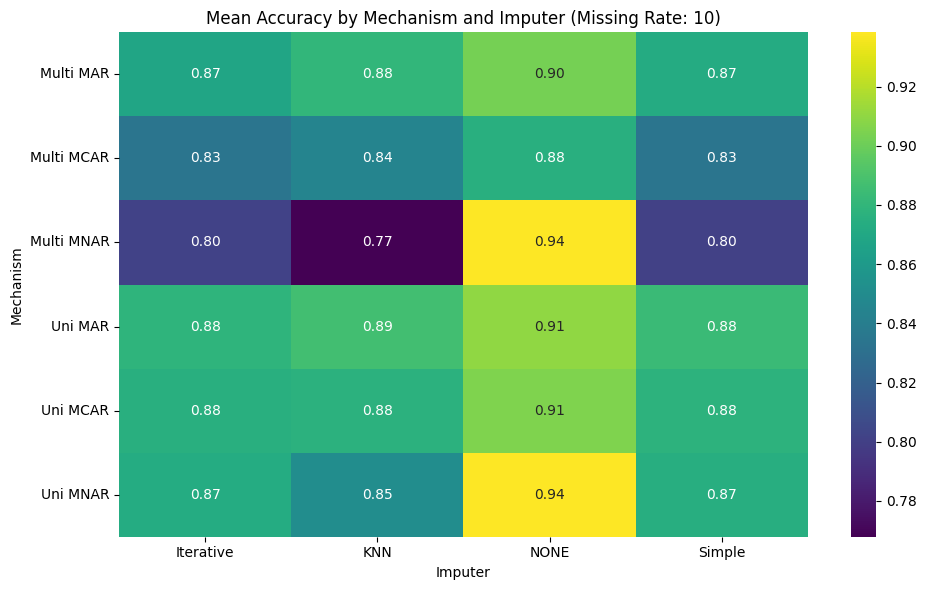

In [23]:
# Pivot the data for plotting
pivot_df = avg_grouped_df.pivot(index="mechanism", columns="imputer", values="mean_accuracy")

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_df, annot=True, cmap="viridis", fmt=".2f")
plt.title(f"Mean Accuracy by Mechanism and Imputer (Missing Rate: {selected_missing_rate})")
plt.xlabel("Imputer")
plt.ylabel("Mechanism")
plt.tight_layout()
plt.show()

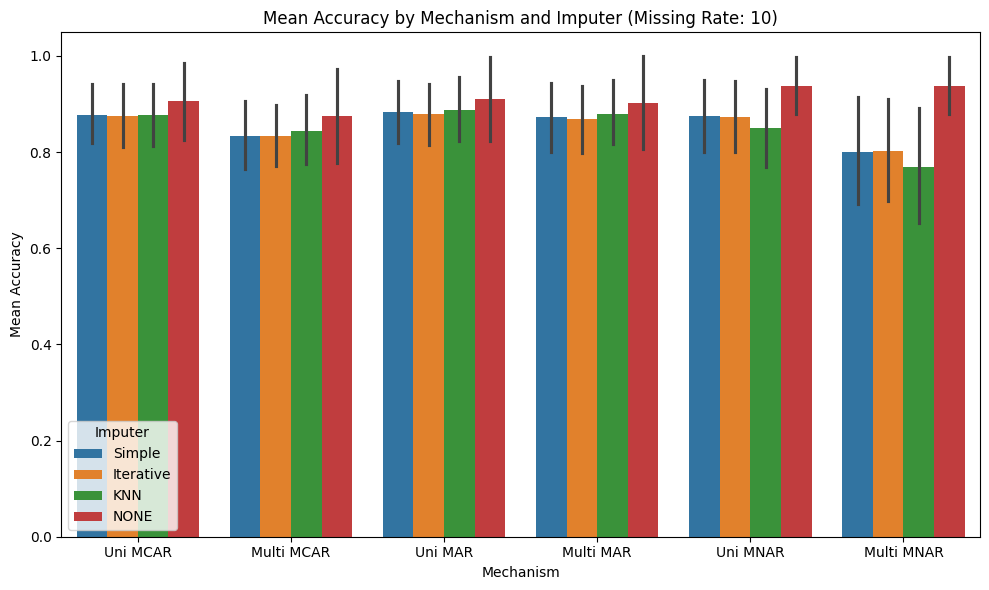

In [24]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=filtered_results_df,
    x="mechanism",
    y="mean_accuracy",
    hue="imputer",
)
plt.title(f"Mean Accuracy by Mechanism and Imputer (Missing Rate: {selected_missing_rate})")
plt.ylabel("Mean Accuracy")
plt.xlabel("Mechanism")
plt.legend(title="Imputer")
plt.tight_layout()
plt.show()

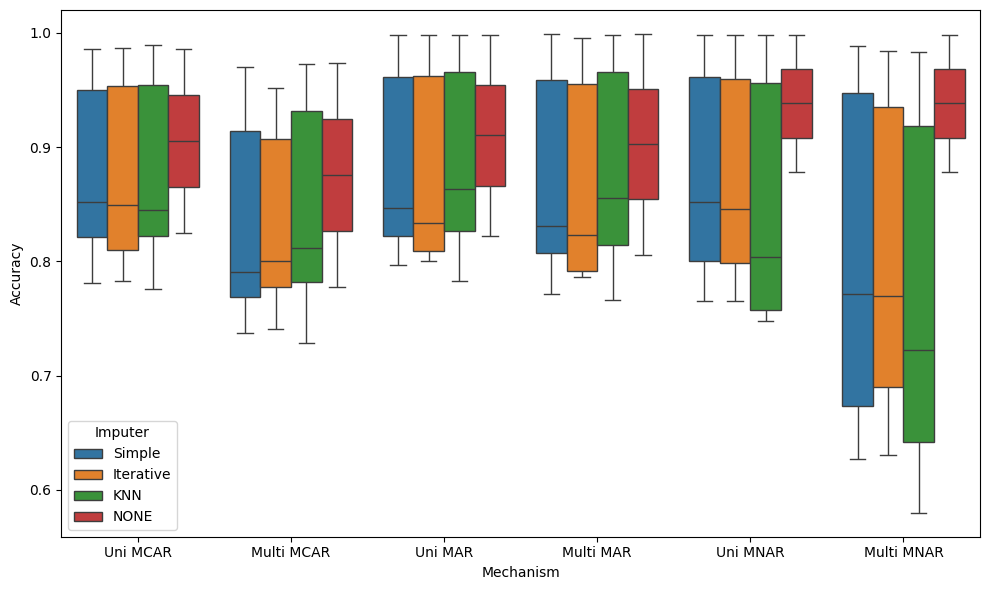

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_results_df,
    x="mechanism",
    y="mean_accuracy",
    hue="imputer",
)
# plt.title(f"Distribution of Accuracies by Mechanism and Imputer (Missing Rate: {selected_missing_rate}%)")
plt.ylabel("Accuracy")
plt.xlabel("Mechanism")
plt.legend(title="Imputer")
plt.tight_layout()
plt.show()


### Predictive Accuracy

In [27]:
filtered_pac_df = pac_df[pac_df["missing_rate"] == MISSING_RATES[0]]
filtered_pac_df

,imputer,mechanism,missing_rate,dataset,numerical_pac,binary_pac
0,Simple,Uni MCAR,10,mobile_price,2193.840000,NaN
1,Iterative,Uni MCAR,10,mobile_price,2193.839942,NaN
2,KNN,Uni MCAR,10,mobile_price,2193.876964,NaN
3,Simple,Multi MCAR,10,mobile_price,373.288798,0.555780
4,Iterative,Multi MCAR,10,mobile_price,373.295512,0.576679
5,KNN,Multi MCAR,10,mobile_price,373.331825,0.495309
6,Simple,Uni MAR,10,mobile_price,1994.460000,NaN
7,Iterative,Uni MAR,10,mobile_price,1994.460096,NaN
8,KNN,Uni MAR,10,mobile_price,1994.452535,NaN
9,Simple,Multi MAR,10,mobile_price,647.431429,0.503333


In [28]:
# pd.mean() ignores np.nan values (these correspond, for example, to no missing data generated in binary variables)
grouped_numerical = (
    filtered_pac_df.groupby(["imputer", "mechanism"])["numerical_pac"]
    .mean()
    .reset_index()
)
grouped_binary = (
    filtered_pac_df.groupby(["imputer", "mechanism"])["binary_pac"]
    .mean()
    .reset_index()
    .dropna()
)

# Turn binary accuracy into error
grouped_binary["binary_pac"] = 1 - grouped_binary["binary_pac"]

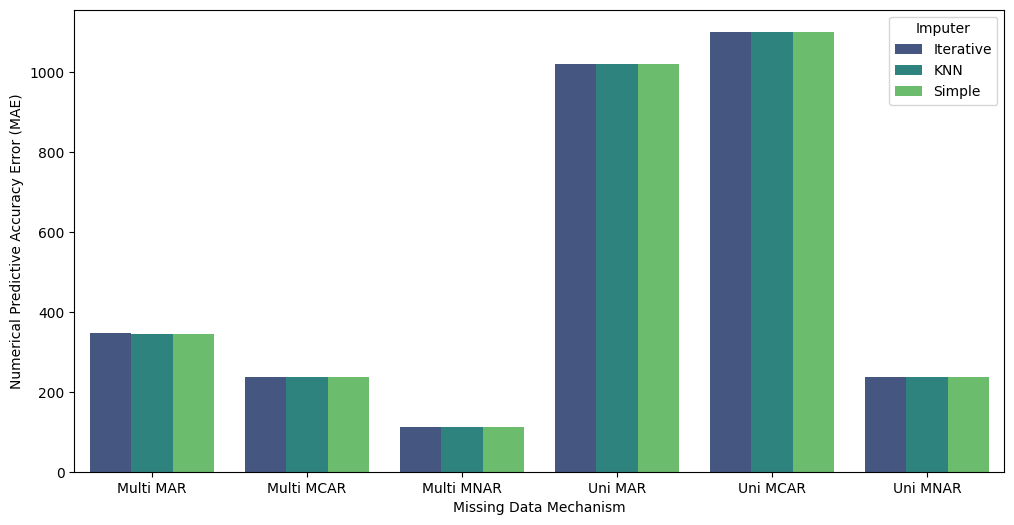

In [29]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_numerical,
    x="mechanism",
    y="numerical_pac",
    hue="imputer",
    palette="viridis",
)
# plt.title("Numerical Predictive Accuracy Error by Imputer and Mechanism")
plt.xlabel("Missing Data Mechanism")
plt.ylabel("Numerical Predictive Accuracy Error (MAE)")
plt.legend(title="Imputer")
plt.show()

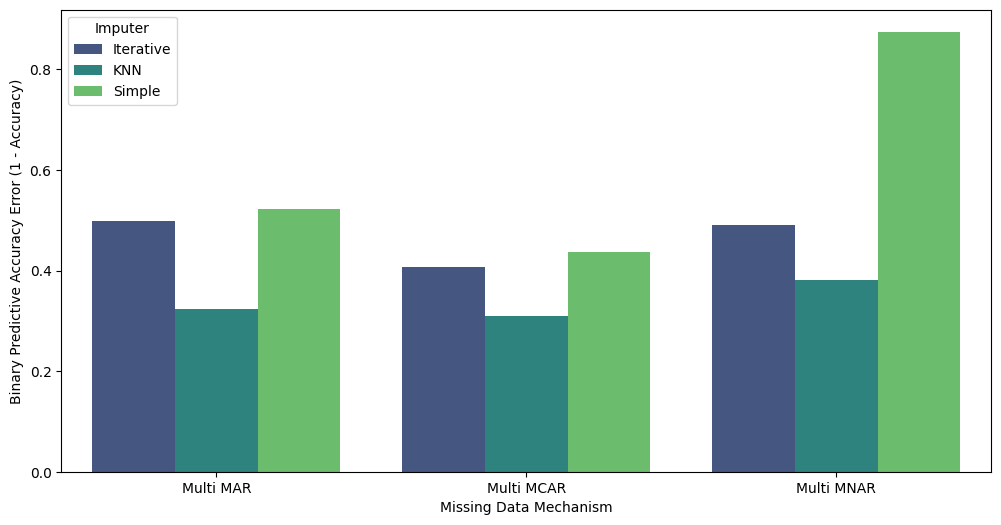

In [30]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=grouped_binary,
    x="mechanism",
    y="binary_pac",
    hue="imputer",
    palette="viridis",
)
# plt.title("Binary Predictive Accuracy Error by Imputer and Mechanism")
plt.xlabel("Missing Data Mechanism")
plt.ylabel("Binary Predictive Accuracy Error (1 - Accuracy)")
plt.legend(title="Imputer")
plt.show()

### Distributional Accuracy

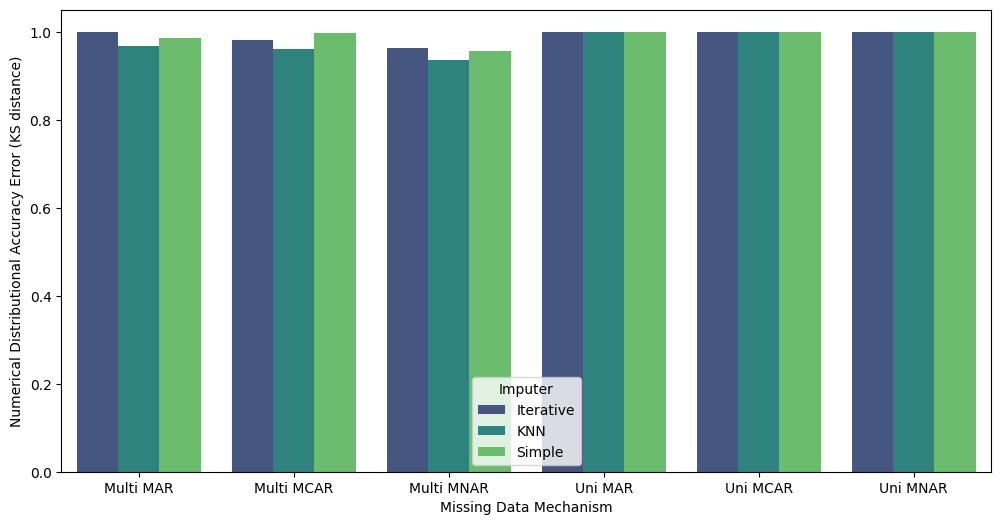

In [31]:
filtered_df = dac_df[pac_df["missing_rate"] == MISSING_RATES[0]]

# Aggregate by mechanism and imputer (averaging over datasets and models)
numerical_dac = (
    filtered_df.groupby(["mechanism", "imputer"])["numerical_dac"]
    .mean()
    .reset_index()
)

# Plot Numerical DAC
plt.figure(figsize=(12, 6))
sns.barplot(
    data=numerical_dac,
    x="mechanism",
    y="numerical_dac",
    hue="imputer",
    palette="viridis",
)
# plt.title("Numerical Distributional Accuracy Error by Mechanism and Imputer")
plt.xlabel("Missing Data Mechanism")
plt.ylabel("Numerical Distributional Accuracy Error (KS distance)")
plt.legend(title="Imputer")
plt.show()

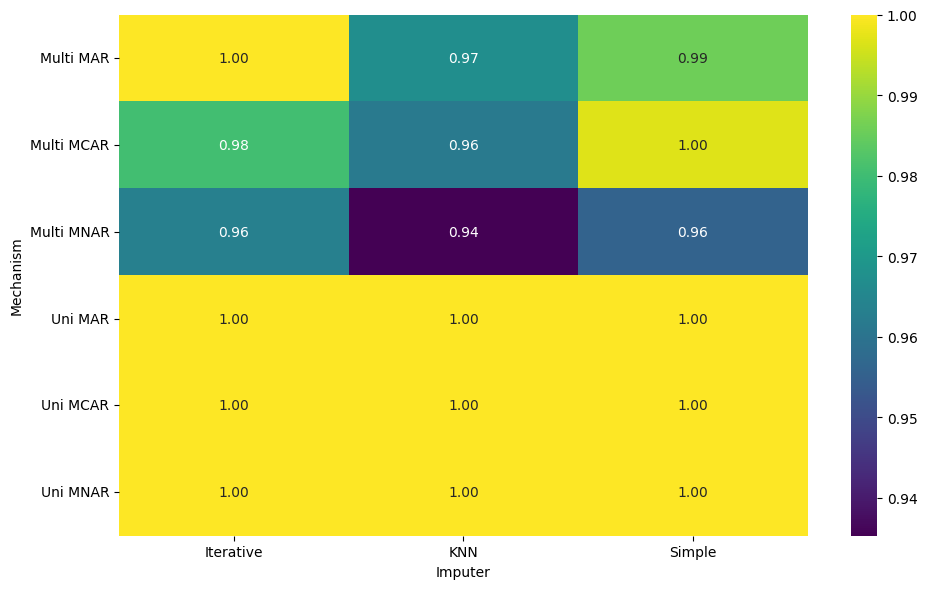

In [32]:
# Pivot the data for numerical DAC
numerical_pivot_df = numerical_dac.pivot(index="mechanism", columns="imputer", values="numerical_dac")

# Plot heatmap for Numerical DAC
plt.figure(figsize=(10, 6))
sns.heatmap(numerical_pivot_df, annot=True, cmap="viridis", fmt=".2f")
# plt.title("Numerical Distributional Accuracy Error by Mechanism and Imputer")
plt.xlabel("Imputer")
plt.ylabel("Mechanism")
plt.tight_layout()
plt.show()
